In [1]:
import autograd.numpy as np
from autograd import grad, hessian, jacobian
from scipy.optimize import minimize

In [2]:
import matplotlib.pyplot as plt
from counterfactual_functions import *
from helper import *

username='ozaltun'

data_dict = load_obj('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/final_data/data_subset_20200304.pickle')

reg_2_num = load_obj('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/GTAP/mapping/reg_2_num.pickle')
comm_2_num = load_obj('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/GTAP/mapping/comm_2_num.pickle')

n = data_dict['n']
g = data_dict['g']
k = data_dict['k']

data_dict['R_hat'] = np.ones((n, g))
data_dict['R_hat'][reg_2_num['usa'], 3] = 2.
data_dict['R_hat'][reg_2_num['usa'], 4] = 1.5

## SETUP 1:
# Farrokhi 2019 oil trade elasticity 19.77
# Ossa 2015 has coal at ~4
# Lets assume NG of ~2
## BETTER SETUP 2:
# Broda and Weinstein 2006 report all three values:
# 22.1 crude oil, 2.01 coal, 2.12 natural gas
data_dict['theta_g'][2] = 2.01
data_dict['theta_g'][3] = 22.1
data_dict['theta_g'][4] = 2.12




X_0 = np.ones(n*g + n)*0.5


eval_F = lambda x: reduced_counterfactual_overdetermined(x, data_dict)
eval_f = lambda x: np.sum(eval_F(x)**2)
# eval_f = lambda x: np.linalg.norm(eval_F(x))

eval_grad_f = grad(eval_f)
eval_jac_F = jacobian(eval_F)
eval_hess_f = hessian(eval_f)
bounds_f = [(1e-14, None) for x in range(n*g+n)]

In [3]:
sol = minimize(eval_f, X_0*2, jac=eval_grad_f, hess=eval_hess_f,\
               method="Newton-CG",bounds=bounds_f, options={'xtol':1e-9,'disp':True})

r_hat_star, w_hat_star = get_values_from_X_reduced(sol.x, data_dict)
E_hat_star = get_E_hat(w_hat_star, r_hat_star, data_dict)

E_hat_star.sum() 

'''Note that you comparing the sum of E_hat doesn't make sense. And we would expect it to change depending on which
country we normalize with respect to. Since the sum of E_hat doesn't take into account the different sizes
of countries. So if you make the normalizing country a small one, thenn the sum will probably be more since you 
are standardizing the small country.
'''

/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.000277
         Iterations: 25
         Function evaluations: 93
         Gradient evaluations: 116
         Hessian evaluations: 25


"Note that you comparing the sum of E_hat doesn't make sense. And we would expect it to change depending on which\ncountry we normalize with respect to. Since the sum of E_hat doesn't take into account the different sizes\nof countries. So if you make the normalizing country a small one, thenn the sum will probably be more since you \nare standardizing the small country.\n"

In [4]:
r_hat_star[reg_2_num['usa'], 2]

1.0188583336600032

In [5]:
r_hat_star[reg_2_num['usa'], 3]

0.7657339973787657

In [6]:
r_hat_star[reg_2_num['usa'], 4]

0.6522676758100622

In [7]:
import seaborn as sns

In [8]:
C_goods = ['farm', 'food', 'coa', 'oil','gas', 'oxd']
F_goods = ['man','bus','oxd','trans','util']
num_2_reg = reverse_dict(reg_2_num)

df_temp = pd.DataFrame(r_hat_star.T)
df_temp.set_index(pd.Series(C_goods), inplace=True)
df_temp.rename(columns=num_2_reg, inplace=True)

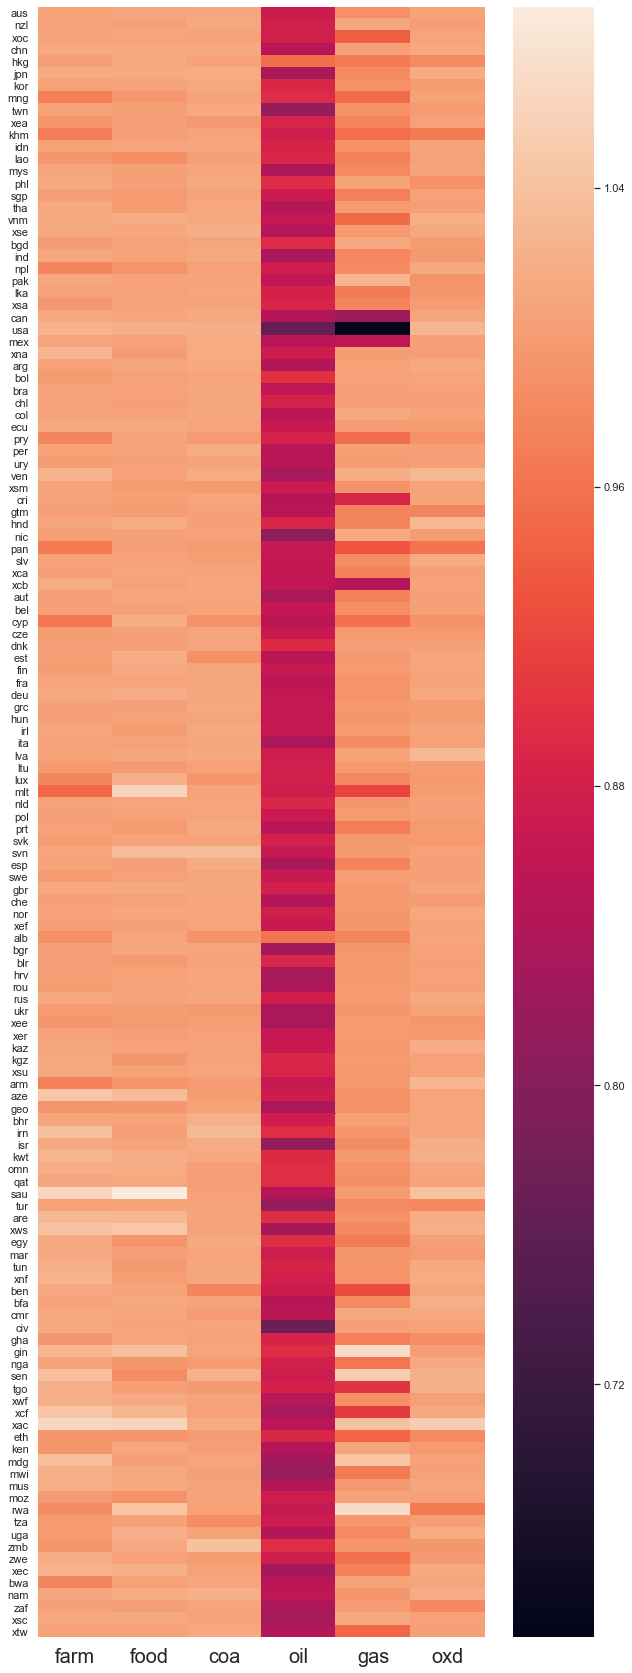

In [9]:
sns.set(font_scale=1) 
fig, ax = plt.subplots(figsize=(10,30))
ax = sns.heatmap(df_temp.T)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

fig.savefig('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/figures/r_ng_broda_values.png', dpi=fig.dpi)

plt.show()

In [10]:
C_goods = ['farm', 'food', 'coa', 'oil','gas', 'oxd']
F_goods = ['man','bus','oxd','trans','util']
num_2_reg = reverse_dict(reg_2_num)

df_temp = pd.DataFrame(w_hat_star.T)
df_temp.set_index(pd.Series(['Wage']), inplace=True)
df_temp.rename(columns=num_2_reg, inplace=True)

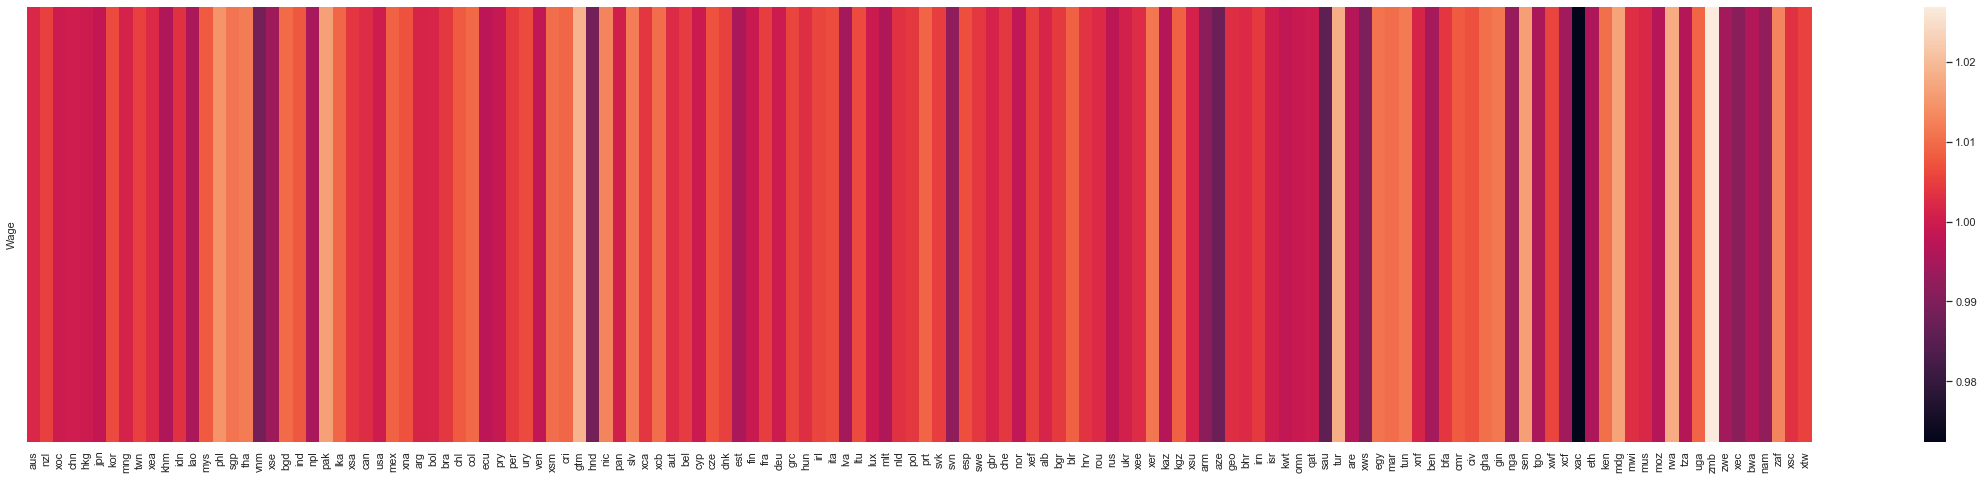

In [11]:
fig, ax = plt.subplots(figsize=(40, 8))
ax = sns.heatmap(df_temp)

plt.show()

In [12]:
def get_X_g_hat(C_g_hat, P_g_goods_hat, D_g_hat, data):
    n = data['n']
    g = data['g']
    k = data['k']
    
    part1 = (P_g_goods_hat.reshape((n, 1, g))/C_g_hat.reshape((1, n, g))) ** (data['theta_g'].reshape((1, 1, g)))
    
    X_g_hat = part1*D_g_hat.reshape((n, 1, g))
    
    return X_g_hat

def get_X_k_hat(C_k_hat, P_k_goods_hat, D_k_hat, data):
    n = data['n']
    g = data['g']
    k = data['k']
    
    part1 = (P_k_goods_hat.reshape((n, 1, k))/C_k_hat.reshape((1, n, k))) ** (data['theta_k'].reshape((1, 1, k)))
    
    X_k_hat = part1*D_k_hat.reshape((n, 1, k))
    
    return X_k_hat
    
def get_system(w_hat, r_hat, data):
    new_dict = {}
    
    n = data['n']
    g = data['g']
    k = data['k']


    new_dict['C_g_hat'] = get_C_g_hat(w_hat, r_hat, data)
    new_dict['E_hat'] = get_E_hat(w_hat, r_hat, data)
    new_dict['P_g_goods_hat'] = get_P_g_goods_hat(new_dict['C_g_hat'], data)
    new_dict['C_k_hat'] = get_C_k_hat(w_hat, new_dict['P_g_goods_hat'], data)
    new_dict['P_k_goods_hat'] = get_P_k_goods_hat(new_dict['C_k_hat'], data)
    new_dict['P_k_hat'] = get_P_k_hat(new_dict['P_k_goods_hat'], data)
    new_dict['D_k_hat'] = get_D_k_hat(new_dict['E_hat'], new_dict['P_k_goods_hat'], new_dict['P_k_hat'], data)
    new_dict['Y_k_hat'] = get_Y_k_hat(new_dict['C_k_hat'], new_dict['P_k_goods_hat'], new_dict['D_k_hat'], data)
    new_dict['D_g_hat'] = get_D_g_hat(new_dict['P_g_goods_hat'], new_dict['C_k_hat'], new_dict['Y_k_hat'], data)
    new_dict['Y_g_hat'] = get_Y_g_hat(new_dict['C_g_hat'], new_dict['P_g_goods_hat'], new_dict['D_g_hat'], data)
    
    new_dict['X_g_hat'] = get_X_g_hat(new_dict['C_g_hat'], new_dict['P_g_goods_hat'], new_dict['D_g_hat'], data)
    new_dict['X_k_hat'] = get_X_k_hat(new_dict['C_k_hat'], new_dict['P_k_goods_hat'], new_dict['D_k_hat'], data)

    return new_dict

In [13]:
counterfactual_dict = get_system(w_hat_star, r_hat_star, data_dict)

In [14]:
counterfactual_dict['Y_g_hat'].shape

(134, 6)

In [15]:
def heat_map(dataset, goods, reg_2_num):
    
    num_2_reg = reverse_dict(reg_2_num)

    df_temp = pd.DataFrame(dataset.T)
    df_temp.set_index(pd.Series(goods), inplace=True)
    df_temp.rename(columns=num_2_reg, inplace=True)
    
    fig, ax = plt.subplots(figsize=(40, 8))
    ax = sns.heatmap(df_temp)

    return fig, ax

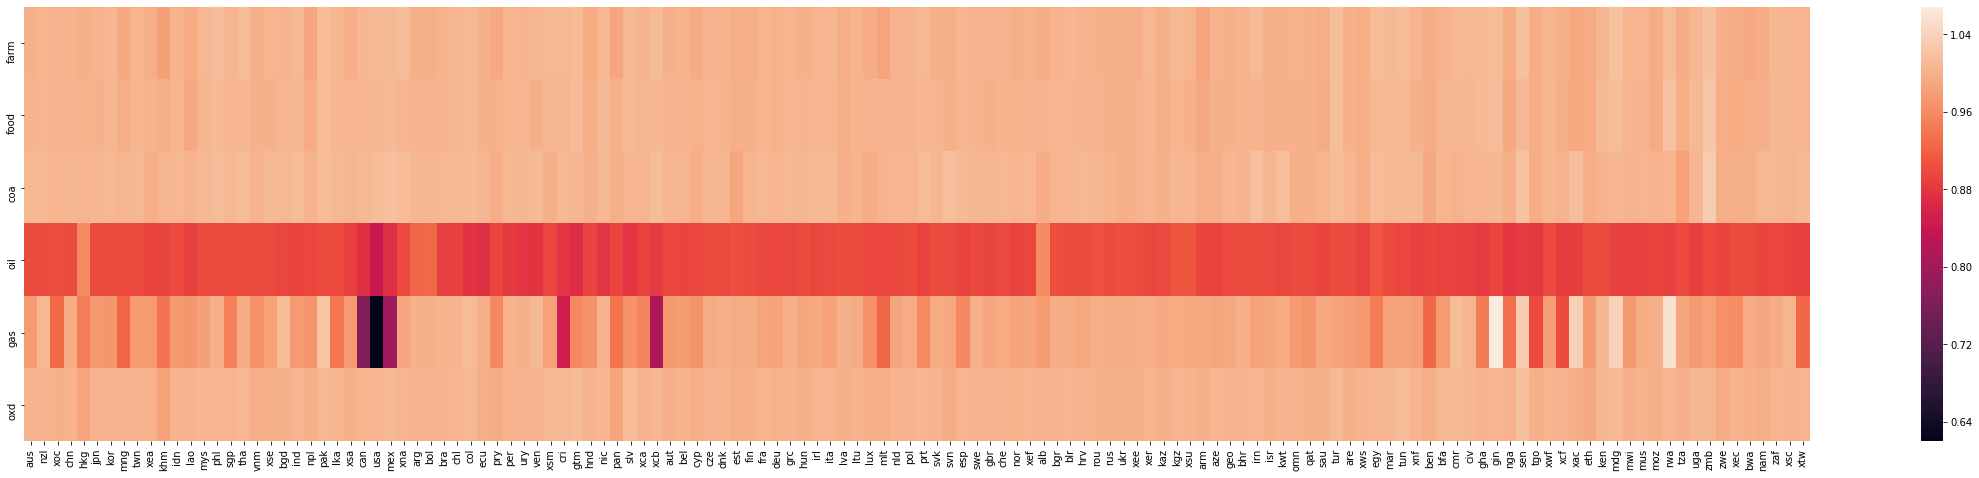

In [69]:
fig, ax = heat_map(counterfactual_dict['C_g_hat'], C_goods, reg_2_num)

In [70]:
plt.show()

In [71]:
dataframe = pd.DataFrame(counterfactual_dict['X_g_hat'][:,:,2])

In [72]:
dataframe.set_index(dataframe.index.to_series().map(num_2_reg), inplace=True)
dataframe.rename(columns=num_2_reg, inplace=True)

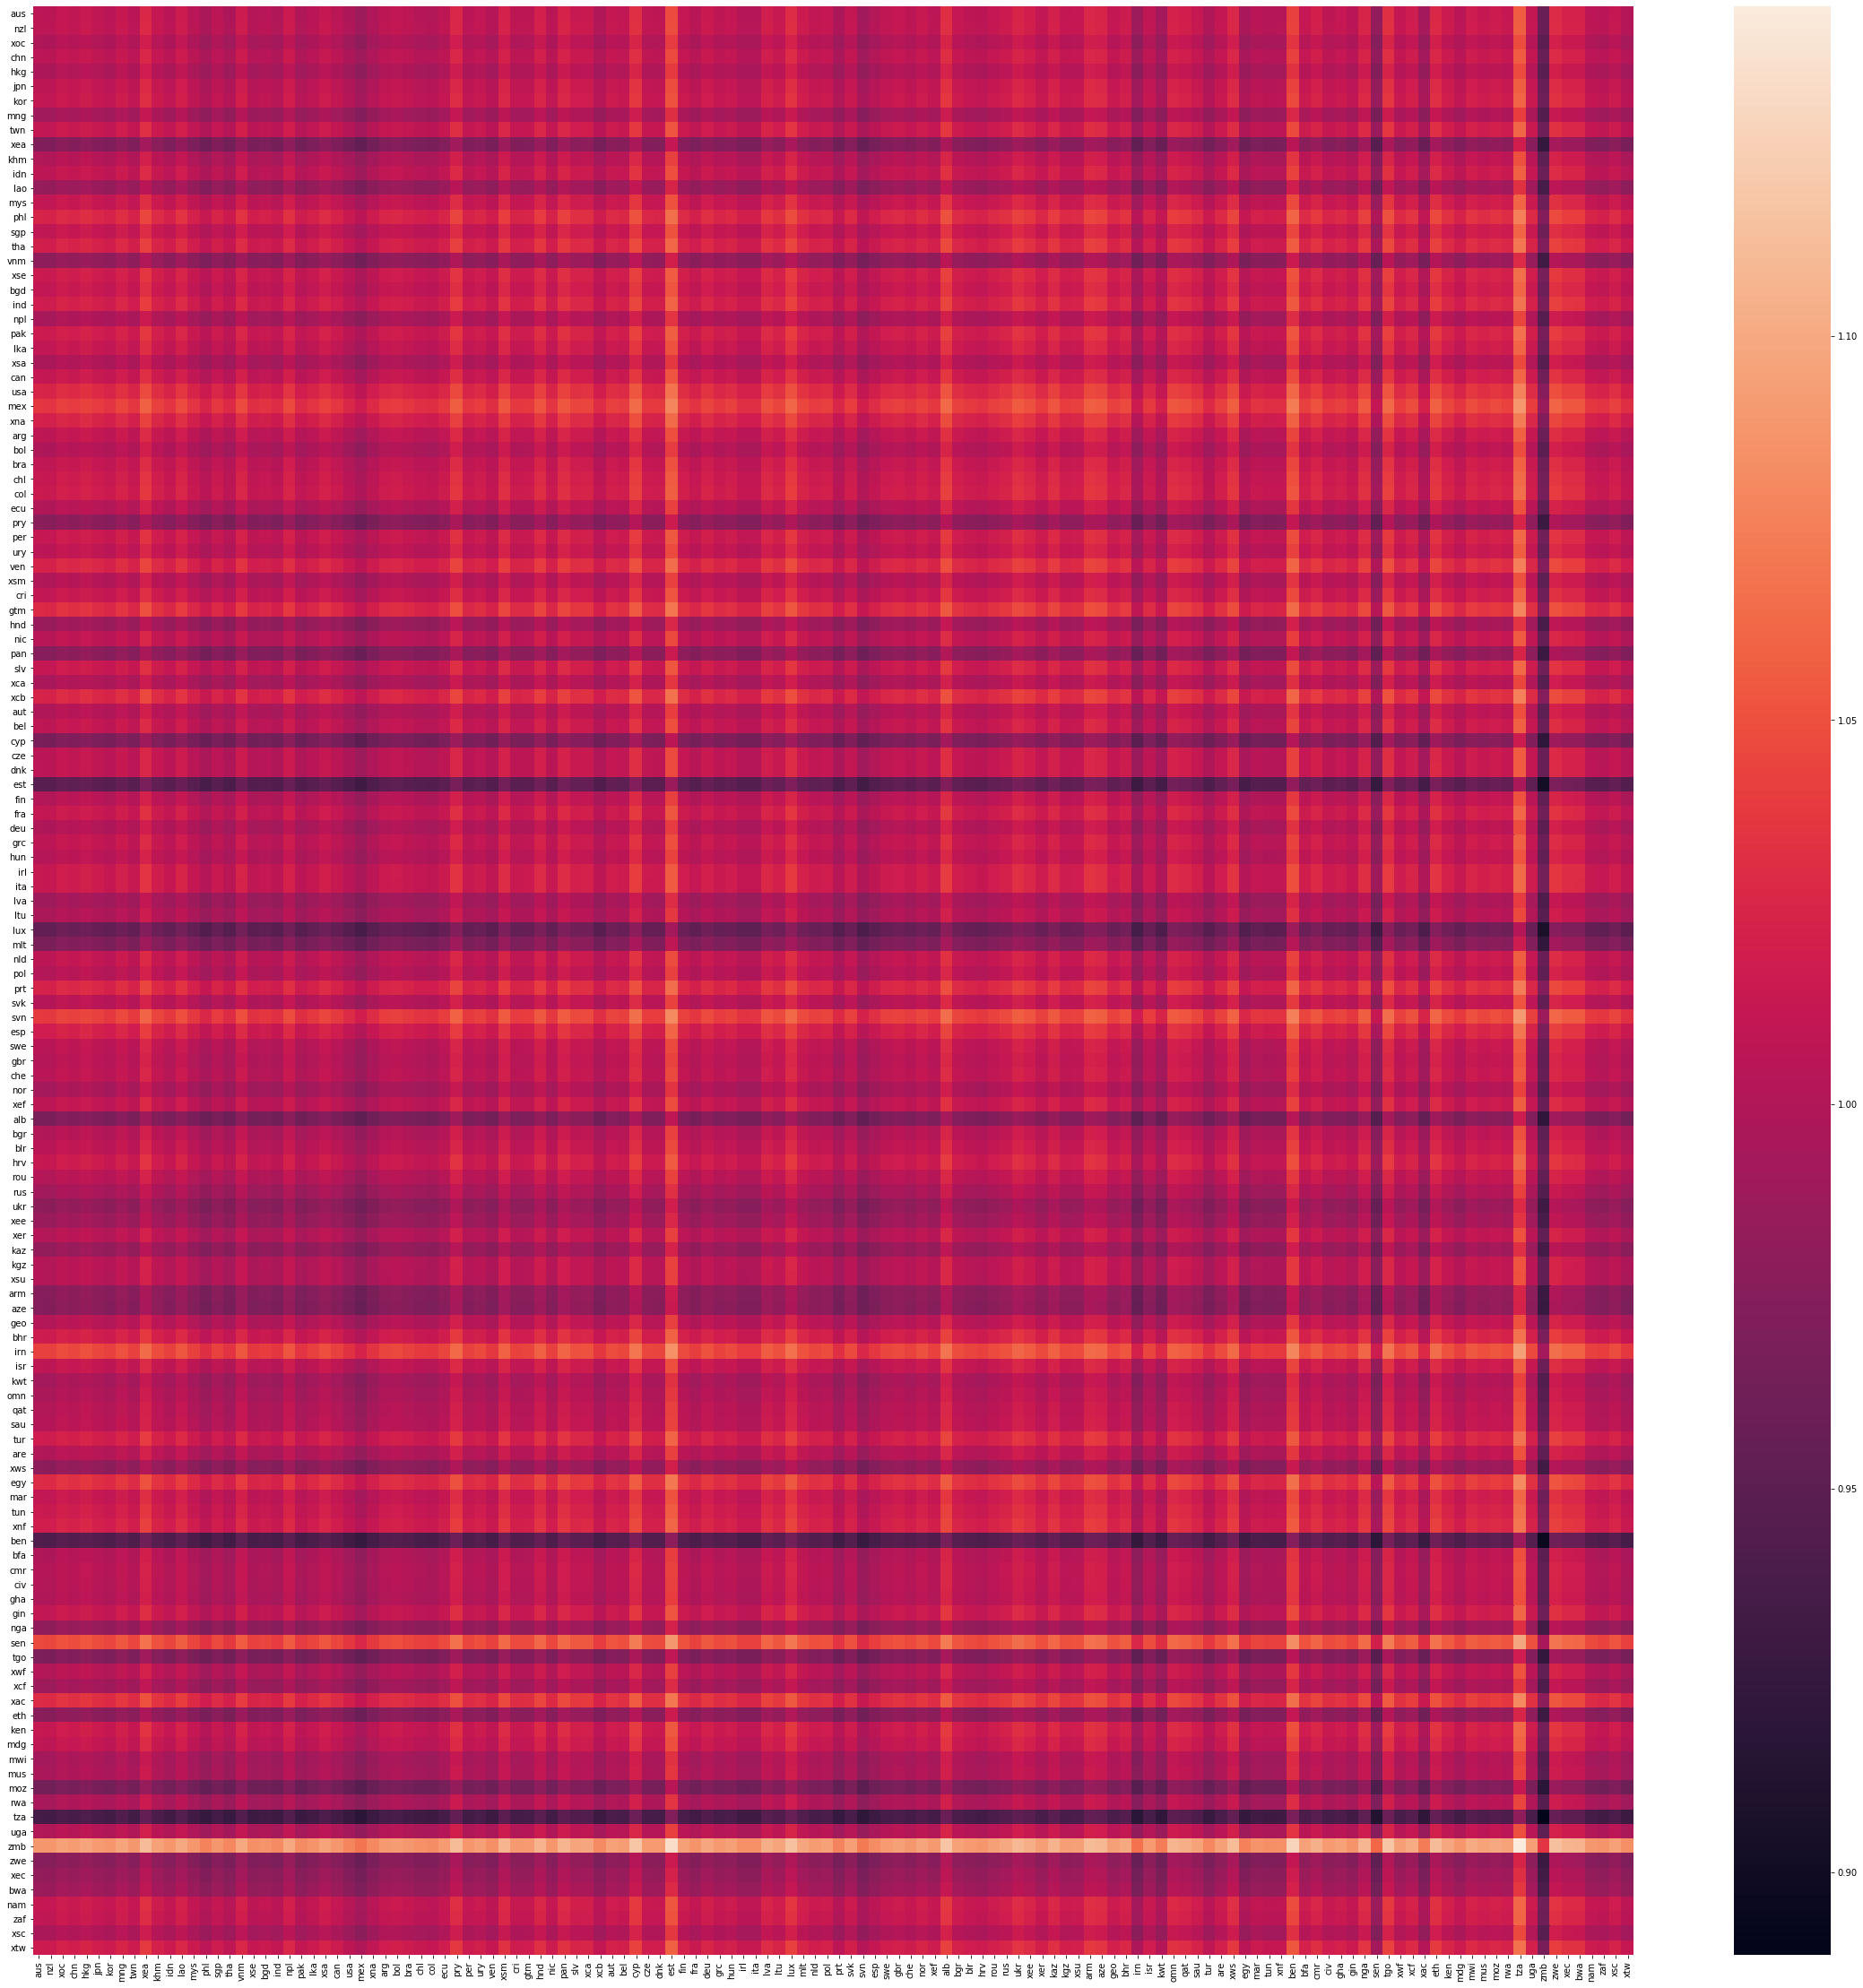

In [73]:
fig, ax = plt.subplots(figsize=(40, 40))
ax = sns.heatmap(dataframe)
plt.show()

In [74]:
counterfactual_dict['X_g_hat'][reg_2_num['usa'], reg_2_num['usa'], 3]

1.617408249998258

In [75]:
counterfactual_dict['X_g_hat'][reg_2_num['usa'], reg_2_num['usa'], 4]

1.0488348749086454

In [76]:
counterfactual_dict['D_g_hat'][reg_2_num['usa'], 2]

1.017043883518324

In [77]:
counterfactual_dict['D_g_hat'][reg_2_num['usa'], 4] # Something is up with demand...

0.816783299639129

In [78]:
counterfactual_dict['D_g_hat'][reg_2_num['usa'], 5]

1.0160473876885658

In [79]:
counterfactual_dict['X_g_hat'][reg_2_num['usa'], reg_2_num['usa'], 2]

1.01685585723109

In [80]:
# We need to play with elasticities!

In [81]:
counterfactual_dict['P_g_goods_hat'][reg_2_num['usa'],2]/counterfactual_dict['C_g_hat'][reg_2_num['usa'],2]

0.9999080179690158

In [86]:
r_hat_star[reg_2_num['usa'],3]

0.7653786349474243

In [87]:
r_hat_star[reg_2_num['usa'],4]

0.4570104353902257